# Buscando a regressão simbólica por meio de um problema de regressão

## O modelo SIR com GPlearn

$\frac{dS}{dt} = -\beta S I$

$\frac{dI}{dt} = \beta S I - \gamma I,$

$\frac{dR}{dt} =  \gamma I$
m
$\beta=$0.3 e $\gamma=$0.1


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from gplearn.genetic import SymbolicRegressor
from sklearn.multioutput import MultiOutputRegressor

# Definir a função do modelo SIR
def sir(t, x, beta=0.3, gamma=0.1):
    return [
        -beta * x[0] * x[1],
        beta * x[0] * x[1] - gamma * x[1],
        gamma * x[1],
    ]

t_start = 0.0
t_end = 100.0
t_step =  0.002 #t_step = 0.002
t_span = (t_start, t_end)

t_eval = np.arange(t_start, t_end, t_step)

# Criando o vetor de condições iniciais
N = 1
I0, R0 = 0.001, 0
S0 = N - I0 - R0
x0_train = np.array([S0, I0, R0])

solution = solve_ivp(sir, t_span, x0_train, t_eval=t_eval)

t_simulated = solution.t
S = solution.y.T[:, 0]
I = solution.y.T[:, 1]
R= solution.y.T[:, 2]

# Resolvendo o produto beta * S * I, 
beta = 0.3
gamma=0.1


# Definir função para calcular as derivadas
# Método Analítico (Derivadas):
def derivadas(S, I, R, beta, gamma):
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
# Calcular as derivadas 
dSdt, dIdt, dRdt = derivadas(S, I, R, beta, gamma)


# Calcular taxas de variação
# Método Numérico (Gradiente Numérico):
#dSdt = np.gradient(solution.y[0], solution.t)
#dIdt = np.gradient(solution.y[1], solution.t)
#dRdt = np.gradient(solution.y[2], solution.t)


In [2]:
# Selecionando os dados de entrada e saída. 
X = np.column_stack((solution.y.T[:, 0],solution.y.T[:, 1]))  # v.a independentes I e S
# Empilhar as derivadas em um array y_true
y_true = np.column_stack((dSdt, dIdt, dRdt))                  # v.a dependente S



In [3]:

est_gp = MultiOutputRegressor(SymbolicRegressor(population_size=10000,    # Número de indivíduos na população inicial
                           generations=100,                               # Número máximo de gerações para a evolução do algoritmo genético.
                       tournament_size=100,                               # Número de indivíduos selecionados para cada torneio durante a seleção.
                    stopping_criteria=0.01,                               # critério de parada
                           p_crossover=0.7,                               # Probabilidade de cruzamento
                           p_subtree_mutation=0.1,                        # Probabilidade de substituição de uma subárvore por um indivíduo.
                           p_hoist_mutation=0.05,                         # Probabilidade de substituir uma subárvore por uma de suas subpartes.
                           p_point_mutation=0.1,                          # Probabilidade de mutação de um nó da árvore
                           max_samples=0.9,                               # maximo de dados da amostra
                           init_depth=(3, 6),                             # profundidade máxima das árvores iniciais 
                           verbose=1,
                           parsimony_coefficient=0.7,                     # equilibrando precisão e interpretabilidade (penalização)
                           function_set=['mul', 'add'],                   # operadores permitidos               
                           random_state=0))                               # semente
est_gp.fit(X, y_true)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    41.93         0.479645        7      0.000268162      0.000266786    156.90m
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    41.93         0.475061       11      0.000899005      0.000892647    289.87m
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    41.93         0.473698        3      7.80956e-05      7.70383e-05    211.08m


MultiOutputRegressor(estimator=SymbolicRegressor(function_set=['mul', 'add'],
                                                 generations=100,
                                                 init_depth=(3, 6),
                                                 max_samples=0.9,
                                                 p_crossover=0.7,
                                                 p_hoist_mutation=0.05,
                                                 p_point_mutation=0.1,
                                                 p_subtree_mutation=0.1,
                                                 parsimony_coefficient=0.7,
                                                 population_size=10000,
                                                 random_state=0,
                                                 stopping_criteria=0.01,
                                                 tournament_size=100,
                                                 verbose=1))

Expressão para saída 1:
mul(mul(X1, mul(X0, -0.973)), 0.300)



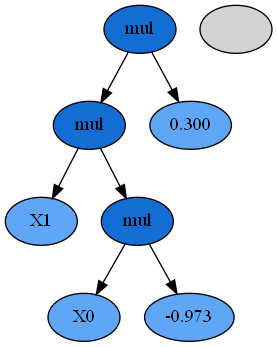

Expressão para saída 2:
mul(X1, mul(mul(add(0.651, -0.910), add(X0, -0.348)), -0.976))



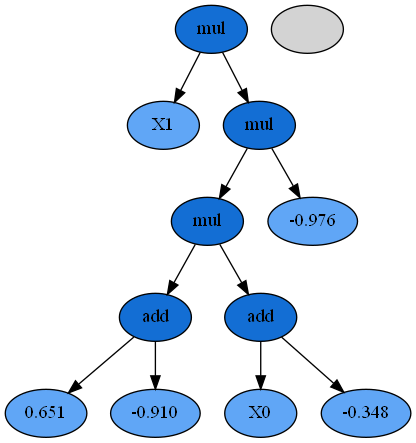

Expressão para saída 3:
mul(X1, 0.101)



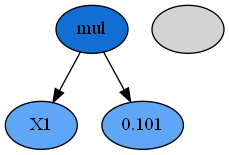

In [4]:
import graphviz 
import pydot
from IPython.display import Image, display

for i, est in enumerate(est_gp.estimators_):
    print(f"Expressão para saída {i+1}:")
    print(est._program)
    print()

    # Plotar a árvore de expressão
    graph = pydot.graph_from_dot_data(est._program.export_graphviz())[0]
    graph.write_png(f'expression_tree_{i}.png')

    # Exibir a imagem
    display(Image(f'expression_tree_{i}.png'))
